[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drdave-teaching/OPIM5509Files/blob/main/OPIM5509_Module5_Files/6_2_understanding_recurrent_neural_networks.ipynb)

# Understanding recurrent neural networks

This notebook contains the code samples found in Chapter 6, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---

[...]

## A first recurrent layer in Keras

The process we just naively implemented in Numpy corresponds to an actual Keras layer: the `SimpleRNN` layer:


In [ ]:
import keras
keras.__version__

'2.9.0'

In [ ]:
from keras.layers import SimpleRNN

There is just one minor difference: `SimpleRNN` processes batches of sequences, like all other Keras layers, not just a single sequence like
in our Numpy example. This means that it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps,
input_features)`.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor
argument. Let's take a look at an example:

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32)) # 10000 max words, each with a 32 dim representation
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 32)                2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(50, return_sequences=True))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, None, 50)          4150      
                                                                 
Total params: 324,150
Trainable params: 324,150
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network.
In such a setup, you have to get all intermediate layers to return full sequences:

In [ ]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(100, return_sequences=True))
model.add(SimpleRNN(100, return_sequences=True))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50))  # This last layer only returns the last outputs.
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, None, 100)         13300     
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, None, 100)         20100     
                                                                 
 simple_rnn_16 (SimpleRNN)   (None, None, 50)          7550      
                                                                 
 simple_rnn_17 (SimpleRNN)   (None, 50)                5050      
                                                                 
Total params: 366,000
Trainable params: 366,000
Non-trainable params: 0
_________________________________________________________________


Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [ ]:
from keras.datasets import imdb
from keras.utils import pad_sequences

max_features = 10000  # number of words to consider as features
maxlen = 100  # cut texts after this number of words (among top max_features most common words)
batch_size = 50

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = pad_sequences(input_train, maxlen=maxlen)
input_test = pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 100)
input_test shape: (25000, 100)


In [ ]:
input_train[322]

array([  86,   95, 5996,  254,    8,  106, 1841,    4,  130,   13, 1695,
        397, 4735,   54,    4, 2325, 5339,   19, 5632,  986,    2, 2371,
         83,    4,  936,    2,  121,  263,   62,   30, 1886, 1902, 1153,
          5, 5531,    2,   19, 9038,   10,   10,    4,  114,    6,  255,
        209, 1804,   11,  558,  778, 5611,    4, 6367,    7, 2890,    4,
          2,    5,    9,    2,    5, 3072,   44,    4, 7021,    6, 2325,
          9, 1412,  730,   39,    4,    2,    8, 3928,    4,  420,    9,
       5413, 4031,   34, 4168,   42,    6,    2,   18, 1954, 2890,   10,
         10,    4,   64, 4631,   11,   14,   22,    9,   15,   12,  417,
        630], dtype=int32)

Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [ ]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32, input_length=maxlen)) #max_features = max_words you kept (10k), 32d embedding, keep first 100 words
model.add(SimpleRNN(64)) # this layer 'spins' 100 times and has 64 red dots
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 32)           320000    
                                                                 
 simple_rnn_18 (SimpleRNN)   (None, 64)                6208      
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 326,273
Trainable params: 326,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 9s 48ms/step - loss: 0.5967 - acc: 0.6622 - val_loss: 0.4534 - val_acc: 0.7900
Epoch 2/10
157/157 [==============================] - 9s 57ms/step - loss: 0.3729 - acc: 0.8450 - val_loss: 0.4309 - val_acc: 0.8230
Epoch 3/10
157/157 [==========================

Let's display the training and validation loss and accuracy:

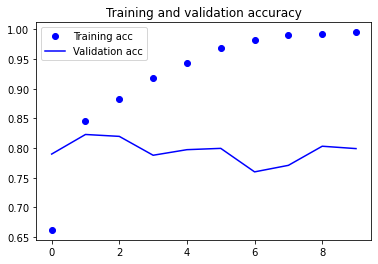

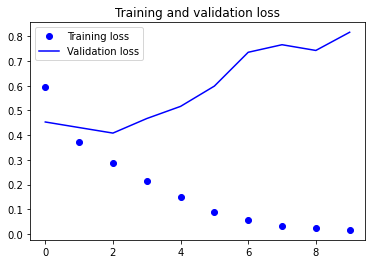

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As a reminder, in chapter 3, our very first naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small
recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is
that our inputs only consider the first 500 words rather the full sequences --
hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some
more advanced layers.

[...]

## A concrete LSTM example in Keras

Now let's switch to more practical concerns: we will set up a model using a LSTM layer and train it on the IMDB data. Here's the network,
similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every
other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you
having to spend time tuning parameters by hand.

In [ ]:
from keras.layers import LSTM, Dropout, GRU

model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen)) #10k common words, 128d, 100 words
model.add(LSTM(64, return_sequences=True, activation='relu', recurrent_dropout=0.2)) #100 rows (words), 64 columns (dimensions)
model.add(GRU(32, activation='relu', recurrent_dropout=0.2)) # 1 row with 32 columns (dense vector for prediction)
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 100, 64)           49408     
                                                                 
 gru (GRU)                   (None, 32)                9408      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,338,849
Trainable params: 1,338,849
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [=======================

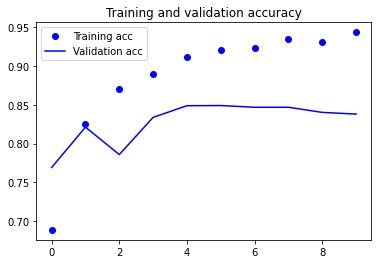

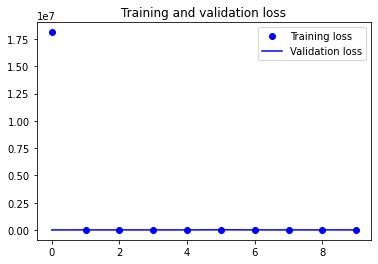

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Monster!
Bidirectional layers, convolution, pooling, stacking, recurrent dropout.

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, Bidirectional, GRU
# define model
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(Conv1D(filters=64, kernel_size=3))
model.add(MaxPooling1D(2))
model.add(Bidirectional(LSTM(30,
                            return_sequences=True, # remember, if stacking layers, you need to return sequences!
                            activation='relu',
                            recurrent_dropout=0.2)))
model.add(GRU(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 100, 128)          1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 98, 64)            24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 49, 64)           0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 49, 60)           22800     
 nal)                                                            
                                                                 
 gru_2 (GRU)                 (None, 20)                4920      
                                                                 
 dropout_2 (Dropout)         (None, 20)              

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 44s 233ms/step - loss: 0.5607 - acc: 0.7365 - val_loss: 0.3772 - val_acc: 0.8326
Epoch 2/10
157/157 [==============================] - 36s 228ms/step - loss: 0.3449 - acc: 0.8641 - val_loss: 0.3376 - val_acc: 0.8496
Epoch 3/10
157/157 [==============================] - 37s 235ms/step - loss: 0.3286 - acc: 0.9008 - val_loss: 0.3267 - val_acc: 0.8544
Epoch 4/10
157/157 [==============================] - 36s 227ms/step - loss: 0.2008 - acc: 0.9281 - val_loss: 0.4218 - val_acc: 0.8316
Epoch 5/10
157/157 [==============================] - 36s 228ms/step - loss: 0.1387 - acc: 0.9496 - val_loss: 0.3832 - val_acc: 0.8576
Epoch 6/10
157/157 [==============================] - 36s 227ms/step - loss: 0.0877 - acc: 0.9733 - val_loss: 0.6644 - val_acc: 0.8448
Epoch 7/10
157/157 [==============================] - 36s 227ms/step - loss: 0.0650 - acc: 0.9835 - val_loss: 0.5965 - val_acc: 0.8442
Epoch 8/10
157/157 [==============================] - 3